# Telco Customer Churn — End-to-End (IBM/Kaggle)

**Autor:** devdanielcoding · **Fecha:** 2025-10-14 (UTC)

Este notebook implementa un pipeline *end-to-end* de churn aplicado al dataset **Telco Customer Churn** (IBM/Kaggle).

Objetivos:
1. Cargar y limpiar los datos (tratamiento de `TotalCharges`, categorías, nulos).
2. EDA y KPIs de negocio (churn rate, MRR at risk, cohorts por `tenure`).
3. Entrenamiento de modelos (Dummy, Regresión Logística, RandomForest; XGBoost opcional).
4. Métricas técnicas (ROC-AUC, PR-AUC, calibración) y métricas de negocio (costo/beneficio).
5. Interpretabilidad (importancias, SHAP opcional).
6. Selección de umbral y generación de un **top-N** para campañas de retención.

> **Nota:** El dataset se descarga desde un espejo público de GitHub. Si falla, ajusta la URL o coloca el CSV en la raíz del notebook.


## 0. Setup e instalación opcional de librerías

In [ ]:
# Si corres en un entorno limpio, descomenta para instalar dependencias adicionales
# %pip install scikit-learn pandas numpy matplotlib seaborn xgboost shap lifelines plotly


## 1. Imports y configuración

In [1]:
import os, io, sys, json, textwrap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
                             confusion_matrix, classification_report, brier_score_loss)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.grid'] = True

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

DATA_URL = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
CSV_LOCAL = Path('Telco-Customer-Churn.csv')


## 2. Carga de datos

In [2]:
# Descarga si no existe localmente
if not CSV_LOCAL.exists():
    try:
        import urllib.request
        urllib.request.urlretrieve(DATA_URL, CSV_LOCAL.as_posix())
        print("Descargado:", CSV_LOCAL)
    except Exception as e:
        print("⚠️ No se pudo descargar automáticamente. Coloca el CSV en la misma carpeta y reintenta.")
        print("Error:", e)

df = pd.read_csv(CSV_LOCAL)
print(df.shape)
df.head()


Descargado: Telco-Customer-Churn.csv
(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 3. Limpieza básica y entendimiento de variables

In [3]:
# Target binario: 'Churn' Yes/No -> 1/0
df['ChurnFlag'] = (df['Churn'].astype(str).str.strip().str.lower() == 'yes').astype(int)

# TotalCharges viene como str y puede contener espacios vacíos -> coaccionar a numérico
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'].replace(' ', np.nan), errors='coerce')

# Resumen de nulos
nulls = df.isna().sum().sort_values(ascending=False)
display(nulls.head(10))

# Imputación simple: TotalCharges con mediana
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())

# Chequeo de valores de categorías
categoricas = df.select_dtypes(include=['object']).columns.tolist()
print("Columnas categóricas:", categoricas)
print("\nValores únicos por variable categórica (muestra):")
for c in categoricas[:8]:
    print(c, "->", df[c].nunique())
    
# Conversión de 'SeniorCitizen' a categoría (0/1 ya es numérica, pero la dejamos como int)
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)

# Selección de features básicas
target = 'ChurnFlag'
drop_cols = ['customerID', 'Churn']  # ID y texto original del target
X = df.drop(columns=drop_cols + [target], errors='ignore')
y = df[target].copy()

X.head()


TotalCharges       11
customerID          0
SeniorCitizen       0
Partner             0
Dependents          0
gender              0
tenure              0
PhoneService        0
InternetService     0
MultipleLines       0
dtype: int64

Columnas categóricas: ['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']

Valores únicos por variable categórica (muestra):
customerID -> 7043
gender -> 2
Partner -> 2
Dependents -> 2
PhoneService -> 2
MultipleLines -> 3
InternetService -> 3
OnlineSecurity -> 3


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65


## 4. KPIs de negocio (Churn rate, MRR at risk, cohorts por tenure)

Churn rate global: 26.54%
MRR total: 456,116.60
MRR at risk (observado en dataset): 139,130.85


C:\Users\devda\AppData\Local\Temp\ipykernel_18096\4237540233.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cohort = df.groupby('tenure_band')['ChurnFlag'].mean().rename('churn_rate')


tenure_band
0-6      0.529372
7-12     0.358865
13-24    0.287109
25-36    0.216346
37-48    0.190289
49-60    0.144231
61-72    0.066098
Name: churn_rate, dtype: float64

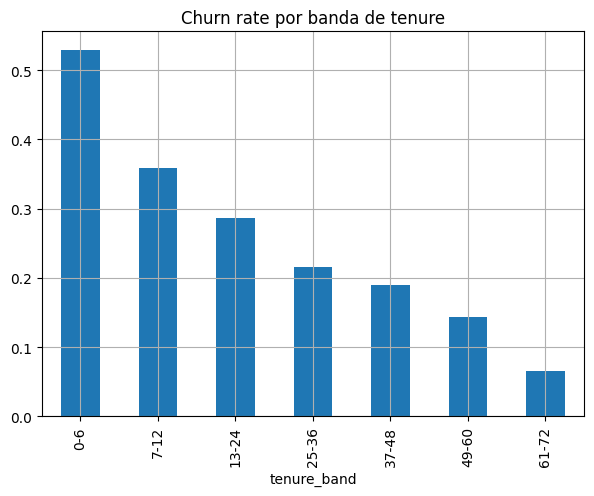

In [4]:
# Churn rate global
churn_rate = y.mean()
print(f"Churn rate global: {churn_rate:.2%}")

# MRR at risk (asumiendo MonthlyCharges como MRR)
mrr_total = df['MonthlyCharges'].sum()
mrr_churned = df.loc[df['ChurnFlag']==1, 'MonthlyCharges'].sum()
print(f"MRR total: {mrr_total:,.2f}")
print(f"MRR at risk (observado en dataset): {mrr_churned:,.2f}")

# Cohorts por tenure (agrupamos por bandas)
bins = [0, 6, 12, 24, 36, 48, 60, 72]
labels = ['0-6', '7-12', '13-24', '25-36', '37-48', '49-60', '61-72']
df['tenure_band'] = pd.cut(df['tenure'], bins=bins, labels=labels, right=True, include_lowest=True)
cohort = df.groupby('tenure_band')['ChurnFlag'].mean().rename('churn_rate')
display(cohort)
cohort.plot(kind='bar', title='Churn rate por banda de tenure'); plt.show()


## 5. Split de entrenamiento/validación (estratificado)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
X_train.shape, X_test.shape, y_train.mean(), y_test.mean()


((5634, 19),
 (1409, 19),
 np.float64(0.2653532126375577),
 np.float64(0.2654364797728886))

## 6. Preprocesamiento (OneHot para categorías, escala para numéricas)

In [6]:
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=np.number).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler(with_mean=False))  # with_mean=False por seguridad con sparse matrices
])

categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=True)

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'
)

print("Numéricas:", len(num_cols), "| Categóricas:", len(cat_cols))


Numéricas: 4 | Categóricas: 15


## 7. Modelos base y comparación

In [7]:
models = {
    'dummy': DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE),
    'logreg': LogisticRegression(max_iter=1000, n_jobs=None, random_state=RANDOM_STATE),
    'rf': RandomForestClassifier(n_estimators=400, random_state=RANDOM_STATE, n_jobs=-1)
}

results = {}
for name, clf in models.items():
    pipe = Pipeline(steps=[('pre', preprocess), ('clf', clf)])
    pipe.fit(X_train, y_train)
    proba = pipe.predict_proba(X_test)[:, 1]
    roc = roc_auc_score(y_test, proba)
    pr = average_precision_score(y_test, proba)  # PR-AUC
    results[name] = {'roc_auc': roc, 'pr_auc': pr, 'model': pipe}
    print(f"{name:>6} | ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f}")

best_name = max(results, key=lambda k: results[k]['pr_auc'])
best = results[best_name]['model']
print("\nMejor por PR-AUC:", best_name)


 dummy | ROC-AUC: 0.500 | PR-AUC: 0.265
logreg | ROC-AUC: 0.842 | PR-AUC: 0.634
    rf | ROC-AUC: 0.819 | PR-AUC: 0.609

Mejor por PR-AUC: logreg


## 8. Curvas ROC & Precision-Recall

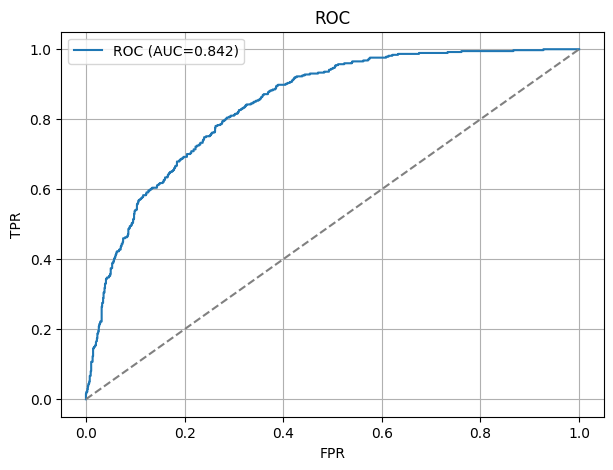

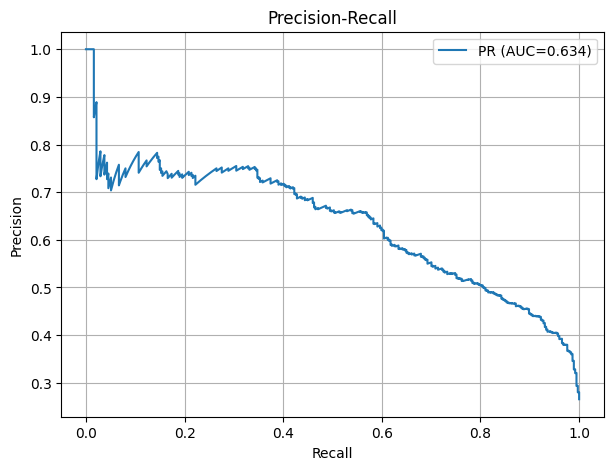

In [8]:
proba = best.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, proba)
prec, rec, thr = precision_recall_curve(y_test, proba)

fig, ax = plt.subplots()
ax.plot(fpr, tpr, label=f'ROC (AUC={roc_auc_score(y_test, proba):.3f})')
ax.plot([0,1],[0,1],'--',color='gray')
ax.set_xlabel('FPR'); ax.set_ylabel('TPR'); ax.set_title('ROC'); ax.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(rec, prec, label=f'PR (AUC={average_precision_score(y_test, proba):.3f})')
ax.set_xlabel('Recall'); ax.set_ylabel('Precision'); ax.set_title('Precision-Recall'); ax.legend()
plt.show()


## 9. Umbral óptimo por métrica y por costo/beneficio

Mejor umbral por F1: 0.27, F1=0.621


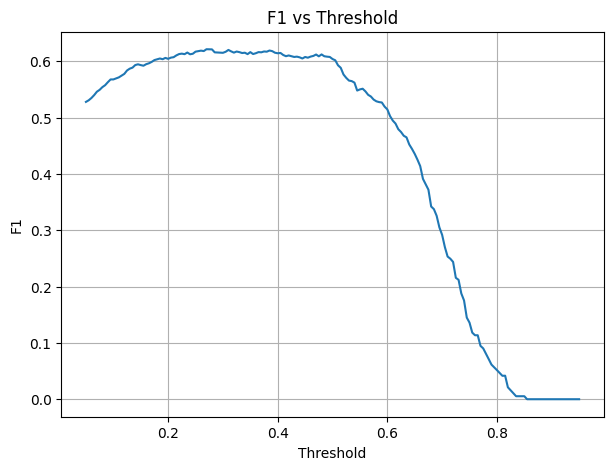

Mejor umbral por beneficio esperado: 0.08, Profit=26890.00


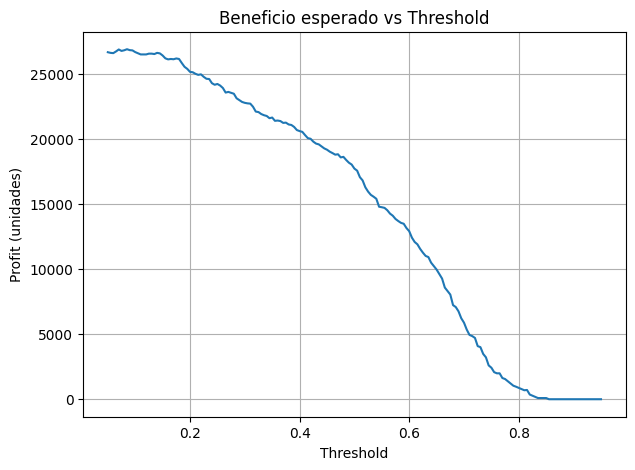

[[475 560]
 [ 13 361]]
              precision    recall  f1-score   support

           0      0.973     0.459     0.624      1035
           1      0.392     0.965     0.558       374

    accuracy                          0.593      1409
   macro avg      0.683     0.712     0.591      1409
weighted avg      0.819     0.593     0.606      1409



In [9]:
from sklearn.metrics import f1_score

# Umbral por F1
thresholds = np.linspace(0.05, 0.95, 181)
f1_scores = []
for t in thresholds:
    preds = (proba >= t).astype(int)
    f1_scores.append(f1_score(y_test, preds))

best_t_f1 = thresholds[int(np.argmax(f1_scores))]
print(f"Mejor umbral por F1: {best_t_f1:.2f}, F1={max(f1_scores):.3f}")

plt.plot(thresholds, f1_scores)
plt.title('F1 vs Threshold'); plt.xlabel('Threshold'); plt.ylabel('F1'); plt.show()

# Costo/beneficio (ejemplo):
# Supón que retener a un cliente cuesta 10 unidades (contacto/oferta)
# y salvarlo genera un beneficio esperado de 100 * prob_churn.
# Solo actuamos en clientes marcados como churn (predicción positiva).
COST_CONTACT = 10.0
BENEFIT_SAVED = 100.0

def expected_profit(t):
    preds = (proba >= t).astype(int)
    # Verdaderos positivos: clientes con churn que marcamos y contactamos
    tp_profit = ( (y_test.values == 1) & (preds == 1) ) * (BENEFIT_SAVED - COST_CONTACT)
    # Falsos positivos: contactamos pero no churn -> solo costo
    fp_cost = ( (y_test.values == 0) & (preds == 1) ) * (-COST_CONTACT)
    return (tp_profit + fp_cost).sum()

profits = [expected_profit(t) for t in thresholds]
best_t_profit = thresholds[int(np.argmax(profits))]
print(f"Mejor umbral por beneficio esperado: {best_t_profit:.2f}, Profit={max(profits):.2f}")

plt.plot(thresholds, profits)
plt.title('Beneficio esperado vs Threshold'); plt.xlabel('Threshold'); plt.ylabel('Profit (unidades)'); plt.show()

# Reporte con umbral elegido
thr_selected = best_t_profit
preds = (proba >= thr_selected).astype(int)
print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds, digits=3))


## 10. Calibración de probabilidades (Brier score)

In [10]:
bs = brier_score_loss(y_test, proba)
print(f"Brier score: {bs:.4f} (más bajo es mejor)")
# (Opcional) CalibratedClassifierCV si necesitas mejor calibración


Brier score: 0.1381 (más bajo es mejor)


## 11. Importancia de características

⚠️ Ajustando: features=45 | importances=19


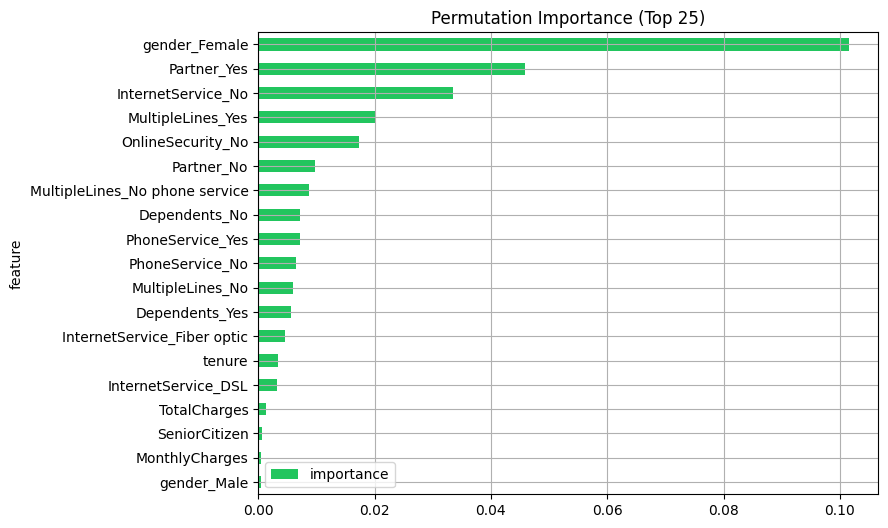

,feature,importance
4,gender_Female,0.101490
7,Partner_Yes,0.045848
17,InternetService_No,0.033499
14,MultipleLines_Yes,0.020298
18,OnlineSecurity_No,0.017317
6,Partner_No,0.009794
13,MultipleLines_No phone service,0.008801
8,Dependents_No,0.007239
11,PhoneService_Yes,0.007239
10,PhoneService_No,0.006529


In [18]:
# === Importancia de características (versión simplificada y robusta) ===
from sklearn.inspection import permutation_importance

# Calcula importancias permutadas
r = permutation_importance(best, X_test, y_test, n_repeats=5,
                           random_state=RANDOM_STATE, n_jobs=-1)

# Recupera nombres de variables después del OneHot
try:
    pre = best.named_steps['pre']
    num_cols = pre.transformers_[0][2]
    cat_cols = pre.transformers_[1][2]
    ohe = pre.named_transformers_['cat']
    cat_names = ohe.get_feature_names_out(cat_cols)
    feature_names = np.concatenate([num_cols, cat_names])
except Exception as e:
    print("⚠️ No se pudieron recuperar nombres expandidos, usando columnas base.")
    feature_names = X_test.columns

# Asegura longitudes iguales
if len(feature_names) != len(r.importances_mean):
    print(f"⚠️ Ajustando: features={len(feature_names)} | importances={len(r.importances_mean)}")
    n = min(len(feature_names), len(r.importances_mean))
    feature_names = feature_names[:n]
    importances = r.importances_mean[:n]
else:
    importances = r.importances_mean

# DataFrame final
imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(25)

# Visualización
imp.plot(kind='barh', x='feature', y='importance', figsize=(8,6),
         title='Permutation Importance (Top 25)', color='#22c55e')
plt.gca().invert_yaxis()
plt.show()

imp.head(10)


## 12. Interpretabilidad con SHAP (opcional)

Modelo para SHAP: LogisticRegression


C:\Users\devda\AppData\Local\Temp\ipykernel_18096\3913157811.py:45: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, feature_names=feature_names, show=True, max_display=20)


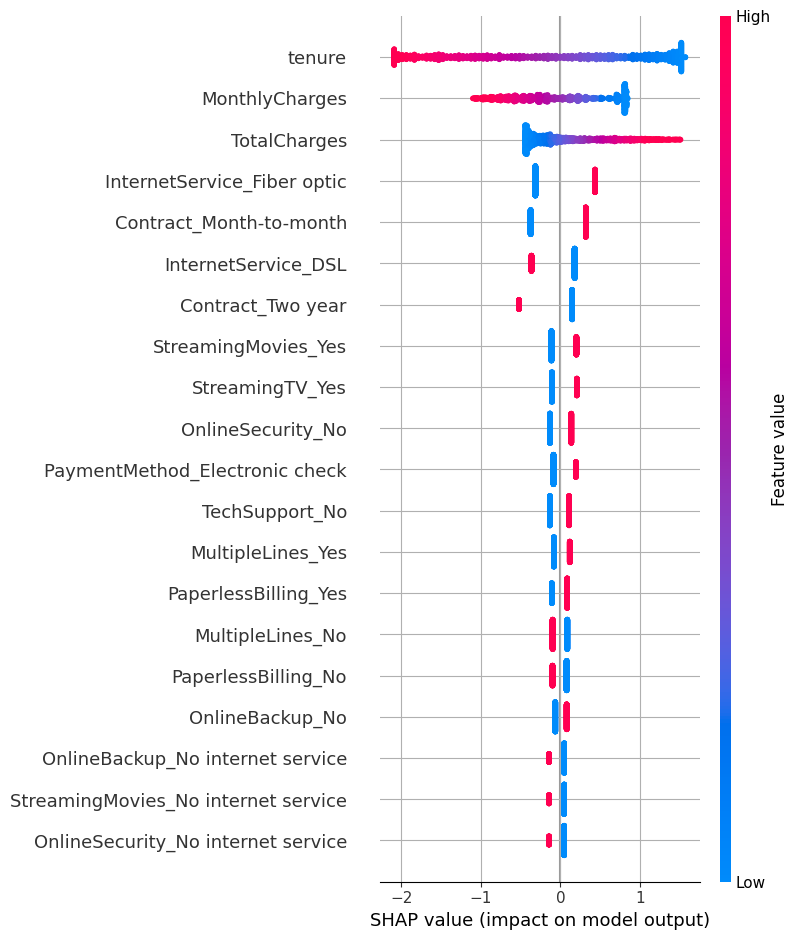

In [20]:
# === 12. Interpretabilidad con SHAP (robusto por tipo de modelo) ===
# %pip install -U shap  # si no lo tienes
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

clf = best.named_steps['clf']
pre = best.named_steps['pre']

# 1) Datos transformados (post OneHot/escala) + nombres de columnas
X_test_trans = pre.transform(X_test)

# Recuperar nombres de features después del OneHot
num_cols = pre.transformers_[0][2]
cat_cols = pre.transformers_[1][2]
ohe = pre.named_transformers_['cat']
cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_names])

# Sparse -> dense si hace falta (LR lo agradece)
X_dense = X_test_trans.toarray() if hasattr(X_test_trans, "toarray") else X_test_trans

# 2) Elegir explainer según el modelo
model_name = type(clf).__name__
print("Modelo para SHAP:", model_name)

if isinstance(clf, RandomForestClassifier):
    # Árboles: TreeExplainer (rápido)
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer(X_dense, check_additivity=False)
elif isinstance(clf, LogisticRegression):
    # Lineales: LinearExplainer (usa link logit)
    explainer = shap.LinearExplainer(clf, X_dense, feature_names=feature_names)
    shap_values = explainer(X_dense)
else:
    # Fallback genérico: KernelExplainer (más lento). Muestra una muestra para demo.
    # Si tu modelo tiene predict_proba, pásalo; si no, usa predict.
    f = clf.predict_proba if hasattr(clf, "predict_proba") else clf.predict
    background = shap.sample(X_dense, 200, random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(f, background)
    shap_values = explainer.shap_values(X_dense[:300])  # limitar por performance

# 3) Plots (elige uno)
try:
    shap.summary_plot(shap_values, feature_names=feature_names, show=True, max_display=20)
except Exception:
    # Para algunos return types (e.g., list por clases) tomamos la clase positiva
    if isinstance(shap_values, list) and len(shap_values) > 1:
        shap.summary_plot(shap_values[1], feature_names=feature_names, show=True, max_display=20)
    else:
        raise


## 13. Exportar top-N clientes en riesgo para campaña

In [21]:
N = 300  # tamaño de campaña
scores = pd.Series(proba, index=X_test.index, name='score_churn')
topN = df.loc[scores.sort_values(ascending=False).head(N).index, ['customerID','MonthlyCharges','tenure','ChurnFlag']].copy()
topN['score_churn'] = scores.loc[topN.index].values
topN = topN.sort_values('score_churn', ascending=False)
topN.head()

# Guardar CSV
topN.to_csv('topN_churn_campaign.csv', index=False)
print('Guardado: topN_churn_campaign.csv')


Guardado: topN_churn_campaign.csv


## 14. Siguientes pasos / Checklist


- [ ] Ajustar hiperparámetros (Grid/Random Search).
- [ ] Validación temporal si cuentas con fechas (evitar fuga de información).
- [ ] Calibración (Platt/Isotonic) y evaluación con **PR-AUC** como métrica principal.
- [ ] Simulación de presupuesto (top-N por periodo) y priorización por **Expected Revenue at Risk** (`MonthlyCharges * prob_churn`).
- [ ] Uplift modeling si dispones de histórico de campañas de retención.
- [ ] Automatizar con GitHub Actions: render a HTML (nbconvert/quarto) y publicar en tu portafolio.
